# Figure 1 creation

In [1]:
%matplotlib widget
import h5py
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patch
import scipy.ndimage as img
import scipy.signal as signal 
import scipy.stats as stat
from alphashape import alphashape
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

In [2]:
condition='anesthesia' #between anesthesia and awake
session='evokedD' #between evokedU, evokedD and spontaneous

In [3]:
original_data_directory=r'/media/mathis/Data/Mathis/Original Data/'

In [4]:
if condition=='awake':
    fs = 100 #Hz
    pixel_spacing = 0.0566 #mm
    if session=='evoked':
        bks_evoked_path = original_data_directory+'gaussian_pos4_ziggy_210908.npy'
        Data = np.load(bks_evoked_path)
    elif session=='spontaneous':
        bks_blank_path = original_data_directory+'blank_ziggy_210908.npy'
        Data = np.load(bks_blank_path)
    mean = np.nanmean(Data)
    nan_loc = np.isnan(Data)
    Data[nan_loc] = mean
    N_trials, Nt, Nx, Ny = Data.shape
    Y, X = np.ogrid[:Nx, :Ny]
    mask =  ((X - 213) ** 2 + (Y - 187) ** 2) <= 193 ** 2

if condition=='anesthesia':
    fs=110 #Hz
    pixel_spacing = 0.0575 #mm
    if session=='evokedD':
        anesth_evokedD_path = original_data_directory+'signal_240306_gaussianD.mat'
        file_anesth_evokedD = h5py.File(anesth_evokedD_path)['signal']
        Data = np.array(file_anesth_evokedD)
    elif session=='evokedU':
        anesth_evokedU_path = original_data_directory+'signal_240306_gaussianU.mat'
        file_anesth_evokedU = h5py.File(anesth_evokedU_path)['signal']
        Data = np.array(file_anesth_evokedU)
    elif session=='spontaneous':
        anesth_blank_path = original_data_directory+'signal_240306_blank.mat' #change it to adapt to your directories
        file_anesth_blank = h5py.File(anesth_blank_path)['signal']
        Data = np.array(file_anesth_blank)
    Data=np.rot90(Data,2,axes=(2,3))
    N_trials, Nt, Nx, Ny = Data.shape
    Y, X = np.ogrid[:Nx, :Ny]
    mask =  ((X - 137) ** 2 + (Y - 125) ** 2) <= 135 ** 2

In [5]:
trial_number=5
test_trial=Data[trial_number]

In [6]:
butt_filt = signal.butter(N=4, Wn=30, btype='lowpass', fs=fs, output='sos')
trial_filt=signal.sosfiltfilt(butt_filt, test_trial, axis=0)

In [7]:
start=53
end=61

In [8]:
Trial=np.copy(trial_filt[start:end]*mask)

## Raw and smoothed data

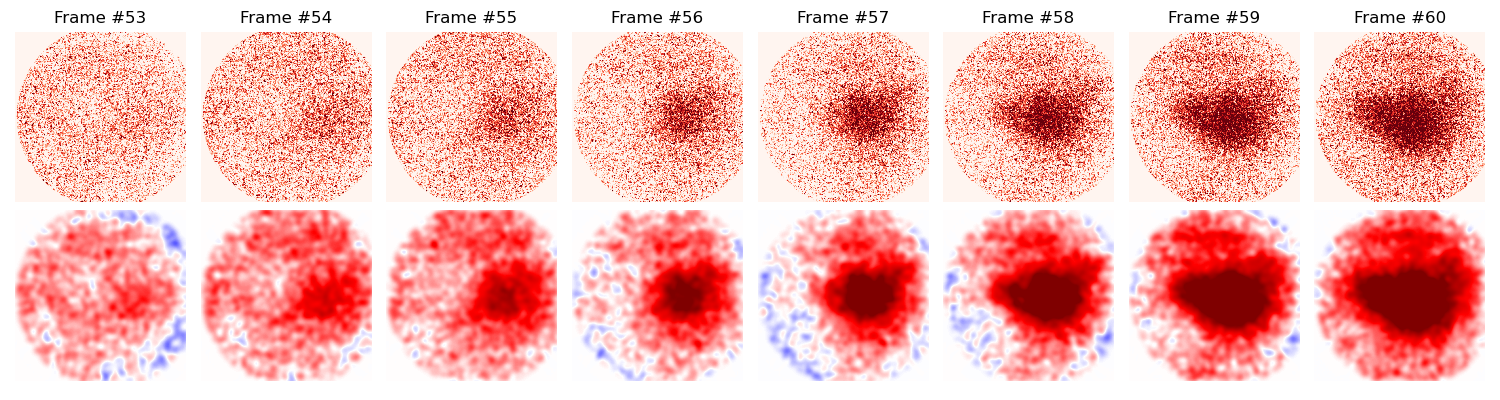

In [9]:
Norm1 = colors.Normalize(vmax=1, vmin=0)
Norm2 = colors.Normalize(vmax=.7, vmin=-.7)

fig1, axs = plt.subplots(2,end-start,layout='tight',figsize=(15,4))
for index,trial in enumerate(Trial):
    axs[0,index].imshow(trial, cmap='Reds', norm=Norm1)
    axs[0,index].set_title(f'Frame #{index+start}')
    axs[0,index].axis('off')
    axs[1,index].imshow(img.gaussian_filter(trial, sigma=4, mode='constant'), cmap='seismic', norm=Norm2)
    axs[1,index].axis('off')


## Threshold

In [10]:
thresh_value=np.percentile(Trial, 99)
Trial_th = Trial - thresh_value
Trial_th[Trial_th<0]=0
T,Y,X = np.where(Trial_th>0)
list_points=[np.vstack((X[T==t],Y[T==t])).T for t in range(end-start)]

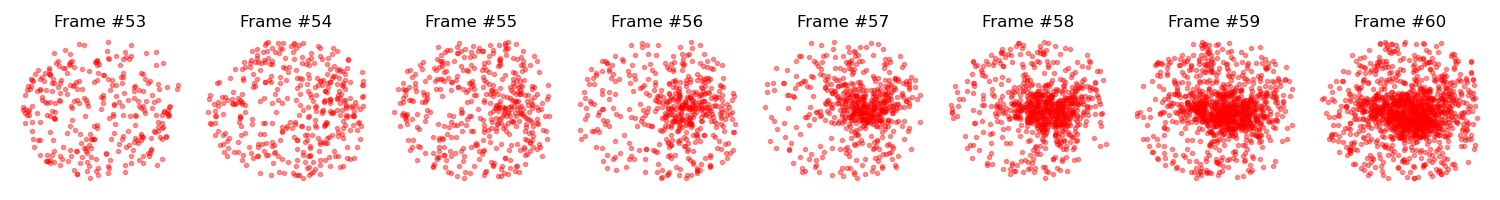

In [27]:
fig2, axs = plt.subplots(1,end-start,layout='tight',figsize=(15,2))
for j in range(end-start):
    axs[j].plot(list_points[j][:,0],list_points[j][:,1],'r.', alpha=.4)
    axs[j].invert_yaxis()
    axs[j].set_title(f'Frame #{j+start}')
    axs[j].axis('off')

## Clustering

In [13]:
eps=17
min_samples=32

In [19]:
Clusters=[]
for points in list_points:
    clust_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labs_dbscan = clust_dbscan.fit_predict(points)
    print(f'{labs_dbscan.max()+1} clusters detected')
    clust_dbscan_points = [points[labs_dbscan == label] for label in np.unique(labs_dbscan) if label != -1]
    list_polyg = [alphashape(clust_dbscan_points[j],0.1) for j in range(labs_dbscan.max()+1)]
    Clusters.append(list_polyg)

0 clusters detected
0 clusters detected
0 clusters detected
1 clusters detected
1 clusters detected
1 clusters detected
1 clusters detected
1 clusters detected


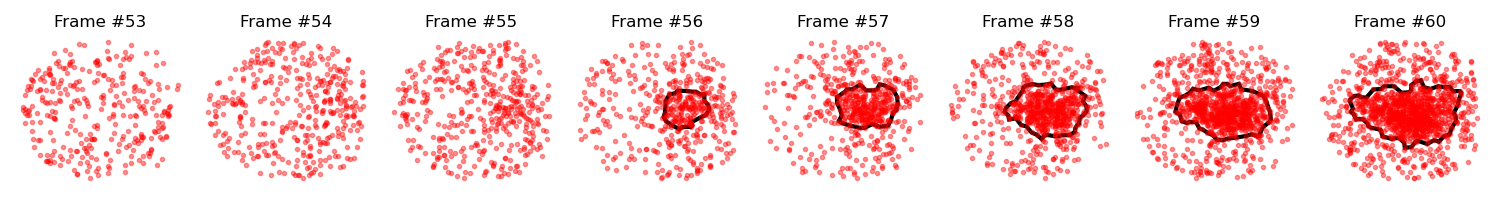

In [28]:
fig3, axs = plt.subplots(1,end-start,layout='tight',figsize=(15,2))
for j in range(end-start):
    axs[j].plot(list_points[j][:,0],list_points[j][:,1],'r.', alpha=.4)
    axs[j].invert_yaxis()
    axs[j].set_title(f'Frame #{j+start}')
    axs[j].axis('off')
    for i,polyg in enumerate(Clusters[j]):
        position=np.vstack(polyg.exterior.xy).T
        axs[j].add_patch(patch.Polygon(position,edgecolor='k',facecolor='none', closed=True,  linewidth=3))

## Overlap between pairwise clusters

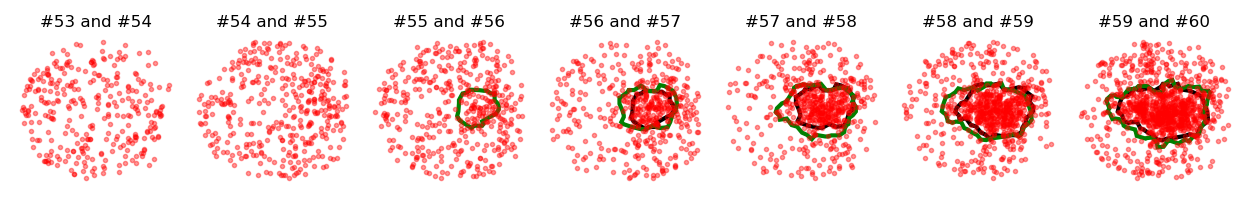

In [36]:
fig4, axs = plt.subplots(1,end-start-1,layout='tight',figsize=(12.5,2))
for j in range(end-start-1):
    axs[j].plot(list_points[j][:,0],list_points[j][:,1],'r.', alpha=.4)
    axs[j].invert_yaxis()
    axs[j].set_title(f'#{j+start} and #{j+start+1}')
    axs[j].axis('off')
    for polyg1 in Clusters[j]:
        position1=np.vstack(polyg1.exterior.xy).T
        axs[j].add_patch(patch.Polygon(position1,edgecolor='k',facecolor='none', closed=True,  linewidth=3))
    for polyg2 in Clusters[j+1]:
        position2=np.vstack(polyg2.exterior.xy).T
        axs[j].add_patch(patch.Polygon(position2,edgecolor='g',facecolor='none', closed=True,  linewidth=3))

end: only the clusters implied in a real moving cluster